<a href="https://colab.research.google.com/github/carlosdcorona/PySpark/blob/main/PySparkExploratoryDataAnalysisTitanic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Group Exercise 14: Spark Exploratory Data Analysis
## 2. Titanic
### Bernardo Samuel Salazar de Hoyos A00825722
### Carlos Daniel Corona Cortez A01656002
### Sebastian Andres Saldaña Cárdenas A01570274
### Sergio Noé Torres Rodríguez A00825706
### Raúl V. Ramírez Velarde
### October 4, 2022


In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://downloads.apache.org/spark/spark-3.1.3/spark-3.1.3-bin-hadoop2.7.tgz
!tar xf spark-3.1.3-bin-hadoop2.7.tgz
!pip install -q findspark

In [ ]:
#All imports
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.3-bin-hadoop2.7"

In [ ]:
import findspark
findspark.init()
from google.colab import files
from pyspark import SparkContext, SparkConf,SQLContext
from pyspark.sql import SparkSession
from pyspark.sql.functions import isnan, when, count, col, lit
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

In [ ]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [ ]:
# create sparksession and sparkcontext
sc = SparkContext.getOrCreate(SparkConf().setMaster("local[*]"))
filepath = '/content/drive/Shareddrives/Infra DS Equipo 4/Classwork 14/titanicV2020.csv'

spark = SparkSession \
    .builder \
    .getOrCreate()

sqlContext = SQLContext(sc)

In [ ]:
df = sqlContext.read.csv(filepath,header=True,inferSchema=True)
df.show(10)

+-----------+--------+------+--------------------+------+---+-----+-----+----------------+-------+-----+--------+
|PassengerId|Survived|Pclass|                Name|   Sex|Age|SibSp|Parch|          Ticket|   Fare|Cabin|Embarked|
+-----------+--------+------+--------------------+------+---+-----+-----+----------------+-------+-----+--------+
|          1|       0|     3|Braund, Mr. Owen ...|  male| 22|    1|    0|       A/5 21171|   7.25|   NA|       S|
|          2|       1|     1|Cumings, Mrs. Joh...|female| 38|    1|    0|        PC 17599|71.2833|  C85|       C|
|          3|       1|     3|Heikkinen, Miss. ...|female| 26|    0|    0|STON/O2. 3101282|  7.925|   NA|       S|
|          4|       1|     1|Futrelle, Mrs. Ja...|female| 35|    1|    0|          113803|   53.1| C123|       S|
|          5|       0|     3|Allen, Mr. Willia...|  male| 35|    0|    0|          373450|   8.05|   NA|       S|
|          6|       0|     3|    Moran, Mr. James|  male| NA|    0|    0|          33087

In [ ]:
df.toPandas().info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   PassengerId  1309 non-null   int32 
 1   Survived     1309 non-null   int32 
 2   Pclass       1309 non-null   int32 
 3   Name         1309 non-null   object
 4   Sex          1309 non-null   object
 5   Age          1309 non-null   object
 6   SibSp        1309 non-null   int32 
 7   Parch        1309 non-null   int32 
 8   Ticket       1309 non-null   object
 9   Fare         1309 non-null   object
 10  Cabin        1309 non-null   object
 11  Embarked     1309 non-null   object
dtypes: int32(5), object(7)
memory usage: 97.3+ KB


In [ ]:
df = df.selectExpr("PassengerId", "Survived", "Pclass", "Name", "Sex", "cast(Age as int) Age", "SibSp", "Parch", "Ticket", "cast(Fare as float) Fare", "Cabin", "Embarked")
df.toPandas().info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int32  
 1   Survived     1309 non-null   int32  
 2   Pclass       1309 non-null   int32  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int32  
 7   Parch        1309 non-null   int32  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float32
 10  Cabin        1309 non-null   object 
 11  Embarked     1309 non-null   object 
dtypes: float32(1), float64(1), int32(5), object(5)
memory usage: 92.2+ KB


In [ ]:
#Get the count of nulls.
from pyspark.sql.functions import col,isnan, when, count
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+-----------+--------+------+----+---+---+-----+-----+------+----+-----+--------+
|PassengerId|Survived|Pclass|Name|Sex|Age|SibSp|Parch|Ticket|Fare|Cabin|Embarked|
+-----------+--------+------+----+---+---+-----+-----+------+----+-----+--------+
|          0|       0|     0|   0|  0|263|    0|    0|     0|   1|    0|       0|
+-----------+--------+------+----+---+---+-----+-----+------+----+-----+--------+



In [ ]:
#We are going to fill age null values by using the mean, same with fare.
#We are going to remove the Cabin column since it has lots of nulls, but with embarked only the registers that are null.
from pyspark.ml.feature import Imputer
def mean_imputer(data,col):
    imputer = Imputer(strategy='mean', inputCols=[col], outputCols=[col+'Imputed'])
    imputer_model = imputer.fit(data)
    data = imputer_model.transform(data)
    return data

df = mean_imputer(df,'Age')
df = mean_imputer(df,'Fare')

df.registerTempTable("Titanic")
df = sqlContext.sql("""SELECT * FROM Titanic WHERE Embarked != 'NA'""")

df = df.drop('Cabin')

df.show()

+-----------+--------+------+--------------------+------+----+-----+-----+----------------+-------+--------+----------+-----------+
|PassengerId|Survived|Pclass|                Name|   Sex| Age|SibSp|Parch|          Ticket|   Fare|Embarked|AgeImputed|FareImputed|
+-----------+--------+------+--------------------+------+----+-----+-----+----------------+-------+--------+----------+-----------+
|          1|       0|     3|Braund, Mr. Owen ...|  male|  22|    1|    0|       A/5 21171|   7.25|       S|        22|       7.25|
|          2|       1|     1|Cumings, Mrs. Joh...|female|  38|    1|    0|        PC 17599|71.2833|       C|        38|    71.2833|
|          3|       1|     3|Heikkinen, Miss. ...|female|  26|    0|    0|STON/O2. 3101282|  7.925|       S|        26|      7.925|
|          4|       1|     1|Futrelle, Mrs. Ja...|female|  35|    1|    0|          113803|   53.1|       S|        35|       53.1|
|          5|       0|     3|Allen, Mr. Willia...|  male|  35|    0|    0|  

In [ ]:
#Get the count of nulls again.
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+-----------+--------+------+----+---+---+-----+-----+------+----+--------+----------+-----------+
|PassengerId|Survived|Pclass|Name|Sex|Age|SibSp|Parch|Ticket|Fare|Embarked|AgeImputed|FareImputed|
+-----------+--------+------+----+---+---+-----+-----+------+----+--------+----------+-----------+
|          0|       0|     0|   0|  0|263|    0|    0|     0|   1|       0|         0|          0|
+-----------+--------+------+----+---+---+-----+-----+------+----+--------+----------+-----------+



## The dimensions of the dataset are: PassengerId, Survived, Pclass, Name, Sex, Age, SibSp, Parch, Ticket, Fare, Embarked which are 11

In [ ]:
df.toPandas().describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,AgeImputed,FareImputed
count,1307.000000,1307.000000,1307.000000,1044.000000,1307.000000,1307.000000,1306.000000,1307.000000,1307.000000
mean,655.319816,0.376435,2.296863,29.818966,0.499617,0.385616,33.223953,29.654170,33.224010
std,377.922205,0.484677,0.836942,14.404204,1.042273,0.866092,51.765987,12.876599,51.746166
min,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,328.500000,0.000000,2.000000,21.000000,0.000000,0.000000,7.895800,22.000000,7.895800
50%,655.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200,29.000000,14.454200
75%,982.500000,1.000000,3.000000,39.000000,1.000000,0.000000,31.275000,35.000000,31.275000
max,1309.000000,1.000000,3.000000,80.000000,8.000000,9.000000,512.329224,80.000000,512.329224


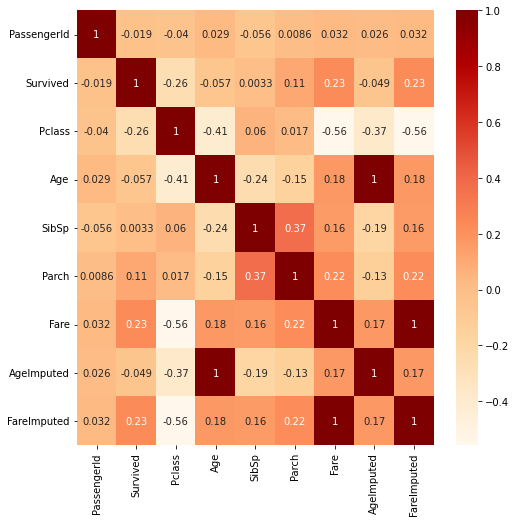

In [ ]:
def correlation_matrix(data,annot,color="OrRd"):
    plt.figure(figsize=(8,8))
    sns.heatmap(data,annot = annot,cmap = color)


correlation_matrix(df.toPandas().corr(),True)

In [ ]:
from pyspark.ml.feature import StringIndexer
def indexer(col,data):
  gender_indexer = StringIndexer(inputCol=col, outputCol=col+'Indexed')
  gender_indexer_model = gender_indexer.fit(data)
  data = gender_indexer_model.transform(data)
  return data

df = indexer('Sex', df)
df = indexer('Embarked', df)

df.show()

+-----------+--------+------+--------------------+------+----+-----+-----+----------------+-------+--------+----------+-----------+----------+---------------+
|PassengerId|Survived|Pclass|                Name|   Sex| Age|SibSp|Parch|          Ticket|   Fare|Embarked|AgeImputed|FareImputed|SexIndexed|EmbarkedIndexed|
+-----------+--------+------+--------------------+------+----+-----+-----+----------------+-------+--------+----------+-----------+----------+---------------+
|          1|       0|     3|Braund, Mr. Owen ...|  male|  22|    1|    0|       A/5 21171|   7.25|       S|        22|       7.25|       0.0|            0.0|
|          2|       1|     1|Cumings, Mrs. Joh...|female|  38|    1|    0|        PC 17599|71.2833|       C|        38|    71.2833|       1.0|            1.0|
|          3|       1|     3|Heikkinen, Miss. ...|female|  26|    0|    0|STON/O2. 3101282|  7.925|       S|        26|      7.925|       1.0|            0.0|
|          4|       1|     1|Futrelle, Mrs. Ja

In [ ]:
def make_array(arr1,arr2):
    return [(i,j) for i in arr1 for j in arr2]

cols_vars = list(df.toPandas().loc[:,~df.toPandas().columns.isin(('PassengerId','Name','Ticket','Age','Fare','Embarked','Sex',
                                                                  'AgeImputed','FareImputed'))].columns) #,'SexIndexed','EmbarkedIndexed'
cols_numericvars = list(df.toPandas()[['Fare','Age']].columns)
grapharr = make_array(cols_vars,cols_numericvars)

In [ ]:
def strip_plots(df,data,orient,fig):
    plt.figure(figsize = fig)
    if orient == 'h':
        sns.stripplot(data = df, x = data[1], y = data[0])
    else:
        sns.stripplot(data = df, x = data[0], y = data[1])

def iter_strip_plots(df,dataarr,orient,fig=(8,5)):
    for col in dataarr:
        strip_plots(df,col,orient,fig)

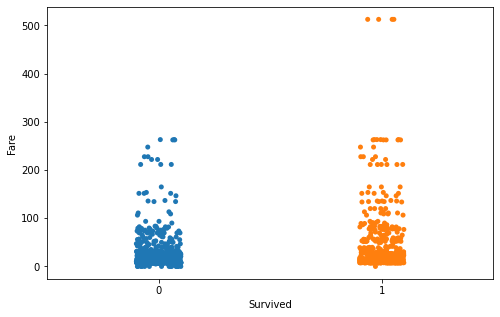

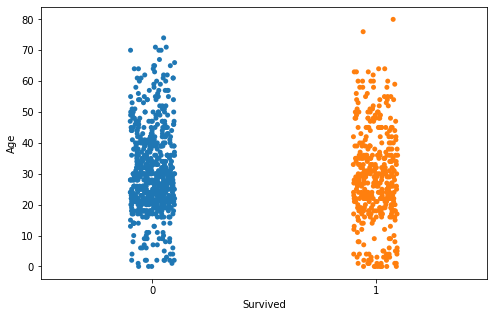

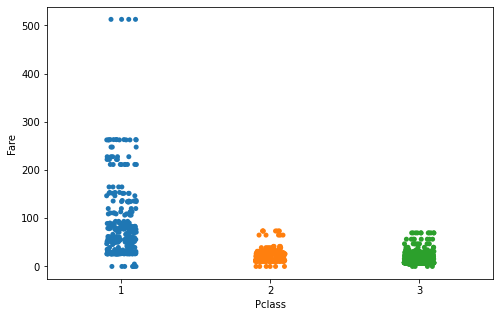

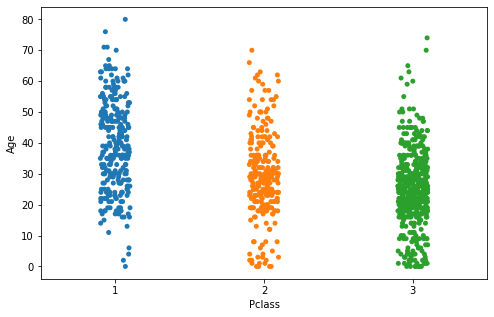

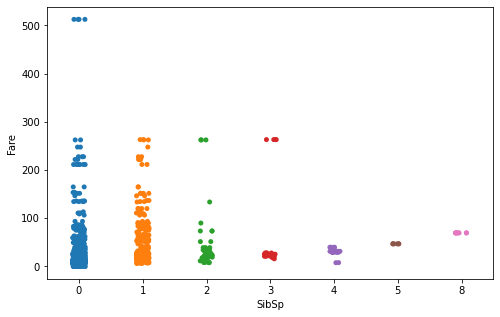

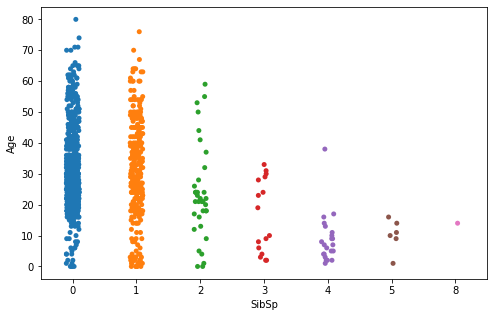

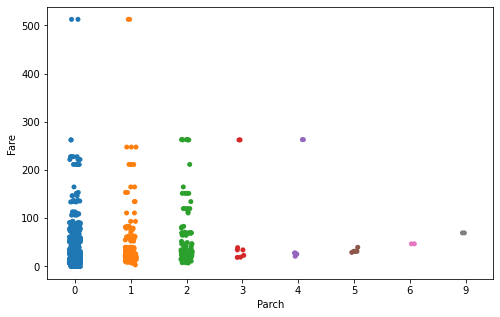

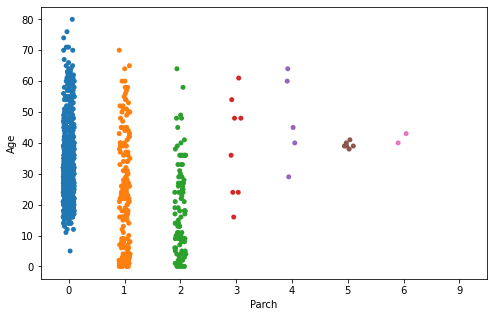

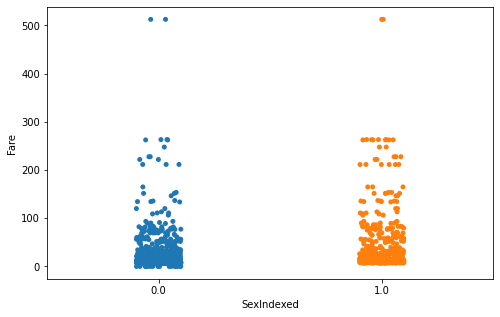

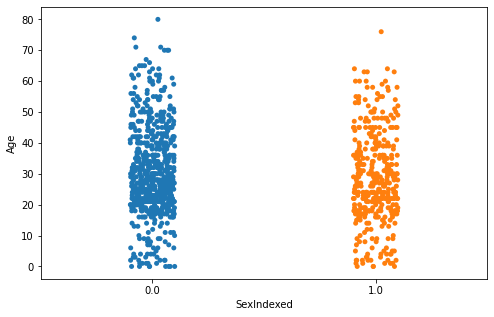

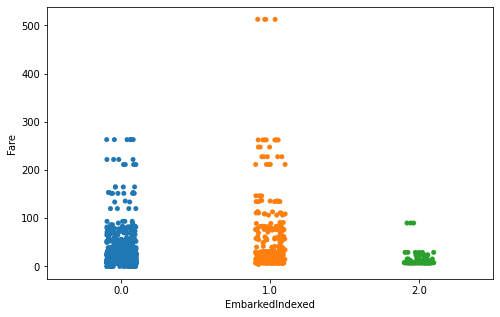

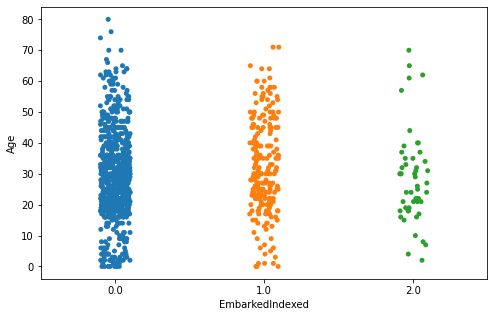

In [ ]:
iter_strip_plots(df.toPandas(),grapharr,'v')

In [ ]:
def scat_plot(data,x,y,h,fig=(8,5)):
    plt.figure(figsize=fig)
    sns.scatterplot(data = data, x = x, y = y, hue = h)

def scat_loop(data,x,y,hue,fig=(8,5)):
    for i in hue:
        scat_plot(data,x,y,i)

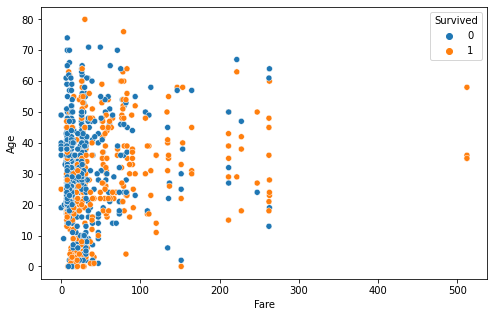

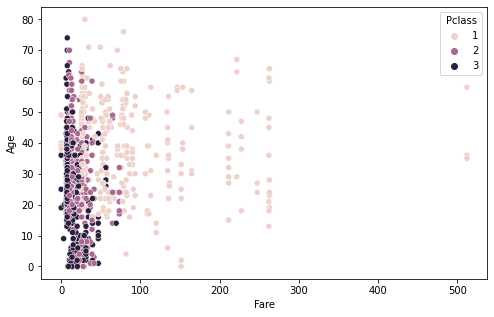

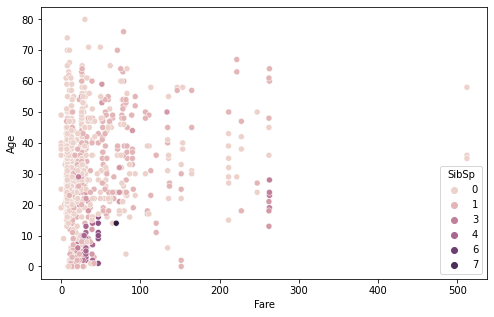

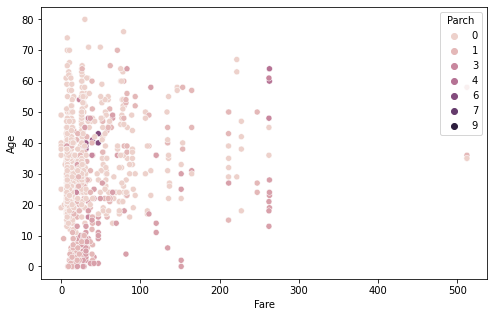

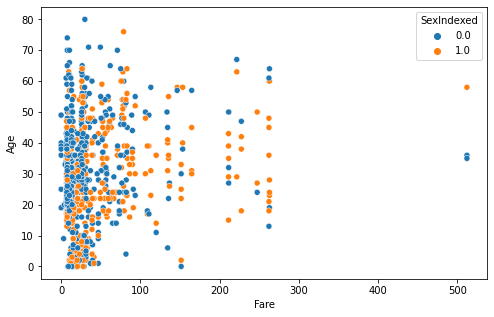

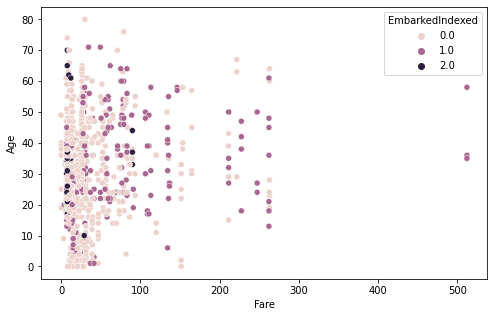

In [ ]:
scat_loop(df.toPandas(),'Fare','Age',cols_vars)

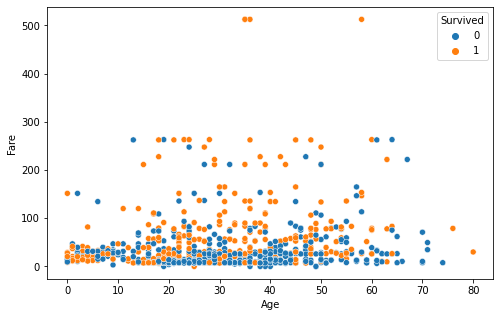

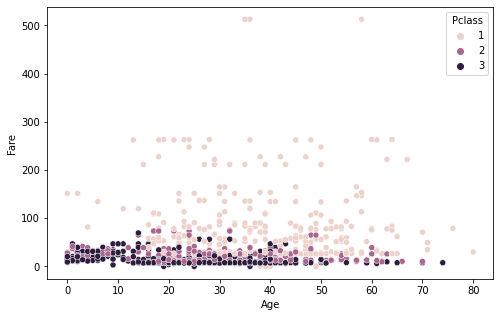

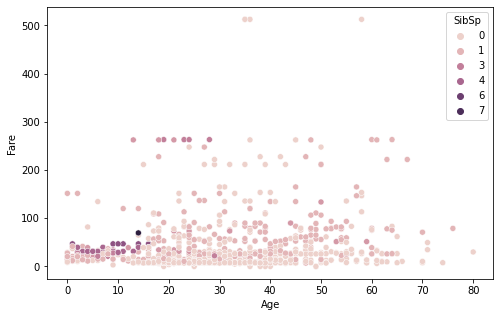

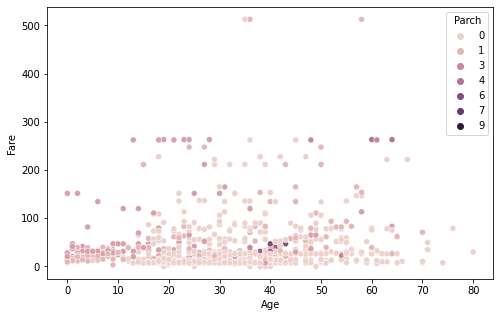

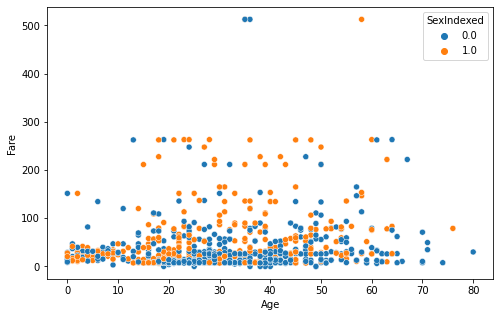

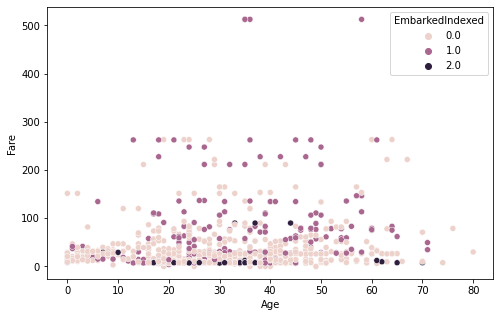

In [ ]:
scat_loop(df.toPandas(),'Age','Fare',cols_vars)

In [ ]:
df.toPandas().corr()['Survived']

PassengerId       -0.019327
Survived           1.000000
Pclass            -0.262483
Age               -0.056808
SibSp              0.003317
Parch              0.109949
Fare               0.232286
AgeImputed        -0.049057
FareImputed        0.232231
SexIndexed         0.687547
EmbarkedIndexed    0.112985
Name: Survived, dtype: float64

## The most relevant variables are Sex, Pclass, Fare, Embarked in that order since there are the ones with greater absolute values of correlation.